In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid')

In [2]:
url = 'http://www.espn.com/nba/seasonleaders/_/league/nba/year/2019'
response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')
cols_tr = (soup.find('table', class_='tablehead')
           .find('tr', class_='colhead'))
cols = [td.text for td in cols_tr.find_all('td')]

rows = list()
for tr in soup.find('table', class_='tablehead').find_all('tr')[2:]:
    if tr.find('td').text != 'RK':
        row = defaultdict()
        for i, td in enumerate(tr.find_all('td')):
            row[cols[i]] = td.text
        rows.append(row)

In [3]:
df = (pd.DataFrame(rows)
      .rename(columns=str.lower)
      .assign(position=lambda x: (x.player.str.split(',', expand=True)[1]
                                  .str.strip()),
              player=lambda x: x.player.str.split(',', expand=True)[0],
              pts=lambda x: x.pts.astype('float64')))

[Text(0, 0.5, ''),
 Text(0.5, 0, 'Points Per Game'),
 Text(0.5, 1.0, 'NBA Guards 2018-2019 PPG')]

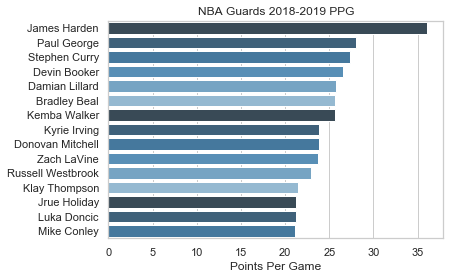

In [4]:
palette = sns.color_palette("Blues_d")
ax = (df.loc[df.position.isin(['SG', 'PG']), ['player', 'pts']]
      .nlargest(15, 'pts')
      .pipe((sns.barplot, 'data'), x='pts', y='player', palette=palette))
ax.set(xlabel='Points Per Game', ylabel='', title='NBA Guards 2018-2019 PPG')

In [5]:
url = 'https://www.nba.com/history/awards/all-nba-team'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')


def team_soup(soup, team_str):
    return soup.find('strong', string=team_str).parent.parent.next_sibling


all_nba = list()

team_soup_html = team_soup(soup, 'FIRST TEAM')
for i, player in enumerate(team_soup_html.stripped_strings):
    if i % 2 == 1:
        player_dict = dict()
        player_dict['player'] = player.split(', ')[0]
        player_dict['all_nba_team'] = 'first'
        all_nba.append(player_dict)

team_soup_html = team_soup(soup, 'SECOND TEAM')
for i, player in enumerate(team_soup_html.stripped_strings):
    if i % 2 == 1:
        player_dict = dict()
        player_dict['player'] = player.split(', ')[0]
        player_dict['all_nba_team'] = 'second'
        all_nba.append(player_dict)
        
team_soup_html = team_soup(soup, 'THIRD TEAM')
for i, player in enumerate(team_soup_html.stripped_strings):
    if i % 2 == 1:
        player_dict = dict()
        player_dict['player'] = player.split(', ')[0]
        player_dict['all_nba_team'] = 'third'
        all_nba.append(player_dict)
        

In [6]:
df_all_nba = (pd.DataFrame(all_nba)
              .query('player != "Official release & voting totals"'))

In [7]:
clay_mask = df.player == 'Klay Thompson'
df = (pd.merge(df, df_all_nba, how='outer', on='player')
      .assign(all_nba_team=lambda x: (x.player.where(clay_mask, 
                                                     (x.all_nba_team
                                                       .fillna('N/A'))))))

In [8]:
def nba_stat_bar_plot(ax, metric):
    palette = ['#33C8FF', '#3396FF', '#3364FF', '#33FF44', '#FF3361']
    hue_order = ['first', 'second', 'third', 'Klay Thompson', 'N/A']
    (df.loc[df.position.isin(['SG', 'PG']), ['player', metric, 'all_nba_team']]
     .nlargest(15, metric)
     .pipe((sns.barplot, 'data'), x=metric, y='player', hue='all_nba_team',
           hue_order=hue_order, orient='h', dodge=False,
           palette=palette, ax=ax))
    ax.set(xlabel=metric.upper(), ylabel='', 
           title='NBA Guards 2018-2019 %s' % metric.upper())

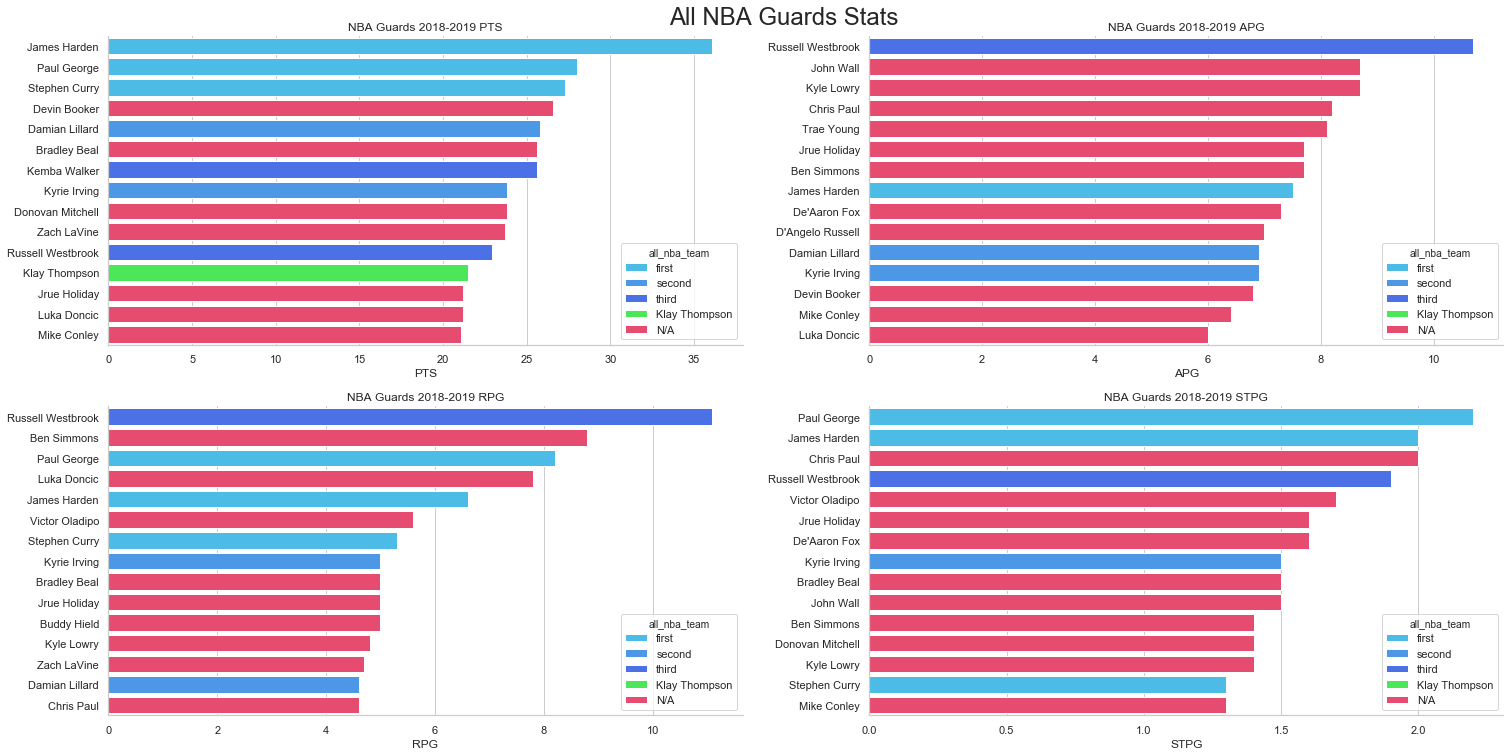

In [9]:
f, axes = plt.subplots(2, 2, figsize=(25, 12.5))
f.suptitle('All NBA Guards Stats', fontsize=24, va='center', ha='center',
           x=0.5, y=0.9)
sns.despine()
stats = ['pts', 'apg', 'rpg', 'stpg']
for stat in stats:
    df[stat] = df[stat].astype('float64')
for i, ax in enumerate(axes.reshape(-1)):
    nba_stat_bar_plot(ax, stats[i])